# Traffic Accidents in Brazillian Federal Highways

In [8]:
from sqlalchemy.exc import OperationalError, DatabaseError
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine
import mysql.connector as mysql
from dotenv import load_dotenv
import geopandas as gpd
import pandas as pd
import logging
import os

# INTRO

## Setting up the working enviroment

*This was not where we started the project, but it should've been.*

This project was developed by Daniel Rocha and Vinicius Hedler, and so it was needed to set up a collaborative workspace. For this we used Github, by creating the repository in [github.com/viniciushedler/traffic-accidents-brazil](https://github.com/viniciushedler/traffic-accidents-brazil). Then, we kept on trying to install everything we need to run our scripts, but because of package conflicts we were having a really bad time, and after trying with some different virtual enviroments we chose virtualenv, and created one through the following windows cmd commands:

pip install virtualenv      *<-- install the virtualenv package*

virtualenv traffic_env      *<-- create the virtualenv*

traffic_env\Scripts\activate        *<-- activate the virtualenv*

pip install ipykernel       *<-- install the ipykernel in this virtualenv*

ipython kernel install --user --name=projectname        *<-- create a new ipykernel*

pip install pipwin      *<-- install the pipwin package,, destined to help windows users with installing packages through pip*

pipwin install package      *<-- installing the packages we wanted ('package' was actually the name of each package we needed)*

## Data collection
Our first step for the project was to collect the data we would be using. From the start we knew the data would be split into two: the geospacial data and the data that would be analyzed. The gathering of both is explained below:

### Data collection - traffic accidents
We started the project looking in Kaggle for data to analyze. Soon we found a database of traffic accidents in Brazil from the years of 2007 to 2021. Some of the columns that qualified this database were "uf" (which stands for "Unidade Federativa" - Brazil states), "municipio" (county), latitude, longitude and "data" (date), besides the base content of the database of course. So we downloaded the database from [here](https://www.kaggle.com/mcamera/brazil-highway-traffic-accidents). 

This big (2GB) database was added to our work enviroment, but was also added in the .gitignore file, so it would not be transfered to the online repository. How we made it available to application is mentioned further.

### Data collection - GeoJSon
Now we needed the GeoJson files to merge with our data and be able to analyze it in a geographical map. It was recomended by Renato Souze (our teacher), to use the files available in [this repository](https://github.com/tbrugz/geodata-br). However, we wanted to analyze the data for each state separetly and for all of them at once. 

In the first situation we could use the county shapes contained in the advised reposiroty, but in the second situation that would lead to ploting the data of thousands of countys all at once, which could lead to major performance issues, and so we decided to gather spacial data from other sources that contained the geometry of each state as one.

We found the data we wanted at 

## Data handling
First, we connect to database:

### Data Cleaning

???

### Creating our Database

???

In [22]:
def connect_to_db():
    load_dotenv()
    db_user = os.getenv("db_user")
    db_password = os.getenv("db_password")
    db_host = 'traffic-accidents.c1npf904zyic.sa-east-1.rds.amazonaws.com'
    db_port = '3306'
    schema = "sys"
    params = f'{db_user}:{db_password}@{db_host}'

    engine = create_engine("mysql+mysqlconnector://%s" % params, max_identifier_length=128, pool_size=1)
    engine.connect()
    Session = sessionmaker(bind=engine)
    session = Session()

    return session

# Analyzing the Data

Now, with the data prepared and saved where and how we need it, we can retrieve it and start analyzing it. 

## Retrieving Data
This is where we gather the data from wherever we saved it to our python scripts to further work with it. As we saved our traffic data and geospacial data separatedly, we also have to retrieve them separatedly and then combine them. Since we're using pandas, this means we are going to save them n dataframes and the merge.

### Retrieving traffic data
For the traffic data, what we need to do is to (again) connect to the database and then query what we want. Now the database serves it's purpose: if we were to simply save the data locally and fully load it, we would have those performance problems (because of the database's size). To avoid that, we send a query to the database and only retrieve what we are interested in at the moment.

This is done by connecting to the database and then using the session to make a query with pandas:

In [23]:
session = connect_to_db()

acidentes_por_estado = pd.read_sql("""
SELECT uf, COUNT(DISTINCT id_acidente) AS qtd_acidente, YEAR(data) as ano 
FROM sys.acidente 
LEFT JOIN sys.localidade ON sys.acidente.id_local=sys.localidade.id_local 
WHERE YEAR(data) = 2020 
GROUP BY uf
""", session.bind)
acidentes_por_estado

,uf,qtd_acidente,ano
0,AC,300,2020
1,AL,636,2020
2,AM,138,2020
3,AP,156,2020
4,BA,3461,2020
5,CE,1568,2020
6,DF,1043,2020
7,ES,2542,2020
8,GO,3225,2020
9,MA,1144,2020


### Retrieving spacial data
For this one we use a library called GeoPandas, which is simply pandas with a new DataFrame type: GeoDataFrame, which can have columns that contain Polygons (or MultiPoligons) variables:

In [16]:
br_states = gpd.read_file("br_states_geo.json")
br_states

c:\Users\vinic\OneDrive\Área de Trabalho\FGV\Ciencia de dados\2021.2 - Segundo periodo\Banco de Dados\traffic-accidents-brazil\traffic_env\lib\site-packages\geopandas\array.py:85: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out


,id,name,geometry
0,AC,Acre,"POLYGON ((-73.33251 -7.32488, -73.27482 -7.350..."
1,AL,Alagoas,"MULTIPOLYGON (((-35.90153 -9.86181, -35.90153 ..."
2,AP,Amapá,"MULTIPOLYGON (((-50.02403 0.85986, -50.02403 0..."
3,AM,Amazonas,"MULTIPOLYGON (((-53.62548 -26.88481, -53.61900..."
4,BA,Bahia,"MULTIPOLYGON (((-38.69708 -17.97903, -38.69708..."
5,CE,Ceará,"MULTIPOLYGON (((-38.47542 -3.70097, -38.47542 ..."
6,DF,Distrito Federal,"POLYGON ((-48.03603 -15.50022, -47.77200 -15.5..."
7,ES,Espírito Santo,"MULTIPOLYGON (((-40.88403 -21.16125, -40.88403..."
8,GO,Goiás,"POLYGON ((-50.15817 -12.41238, -50.15942 -12.4..."
9,MA,Maranhão,"MULTIPOLYGON (((-42.12375 -2.80069, -42.12375 ..."


### Merging traffic and spatial data:
Now that we have all the data we needed, we can merge the dataframes to then analyze them. For that we merge the dataframes on the columns "uf" (from traffic) and "id" (from spatial), that contain the UF code of a state. We could do the same but with countys (and we actually do, just not here). The merge is inner, because we only want the occurencies of a given state (no None or similar in the "uf" column). Note that at the end we drop the column "id" because it is the same as column "uf", but with a *slightly* worse name.

In [24]:
geo_acidentes_por_estado = gpd.GeoDataFrame(acidentes_por_estado.merge(right=br_states, left_on="uf", right_on="id", how="inner")).drop("id", axis=1)

## Ploting the data
Now that we have a suitable GeoDataFrame we can visualize it. To do so it's enough to use 'geodataframe.plot', which is a GeoPandas method that calls the matplotlib library to plot the data. The 'column' parameter defines which columns values are going to be analyzed.

c:\Users\vinic\OneDrive\Área de Trabalho\FGV\Ciencia de dados\2021.2 - Segundo periodo\Banco de Dados\traffic-accidents-brazil\traffic_env\lib\site-packages\geopandas\plotting.py:38: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
c:\Users\vinic\OneDrive\Área de Trabalho\FGV\Ciencia de dados\2021.2 - Segundo periodo\Banco de Dados\traffic-accidents-brazil\traffic_env\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


<AxesSubplot:>

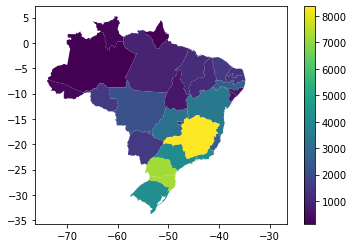

In [26]:
geo_acidentes_por_estado.plot(column="qtd_acidente", legend=True)

## Accidents by state
The example showed above was about the amount of accidents in each state which was the first thing we were interested in evaluating. We can't really see a regional pattern, not even the one of population, since São Paulo has a lot more inhabitants than Minas Gerais and a lot less accidents.

## Lethality by state
We've seen how many accidents occured by state, but that doesn't tell us how bad these accidents are. One way to see this is by calculating in an average how many people die per accident:

In [36]:
session = connect_to_db()

letalidade_por_estado = pd.read_sql("""
SELECT uf, AVG(qtd_mortos) AS letalidade, YEAR(data) as ano 
FROM sys.acidente 
LEFT JOIN sys.localidade ON sys.acidente.id_local=sys.localidade.id_local 
WHERE YEAR(data) = 2020 
GROUP BY uf
""", session.bind)
geo_letalidade_por_estado = gpd.GeoDataFrame(letalidade_por_estado.merge(right=br_states, left_on="uf", right_on="id", how="inner")).drop("id", axis=1)
geo_letalidade_por_estado

,uf,letalidade,ano
0,MG,0.1304,2020
1,GO,0.1226,2020
2,BA,0.1873,2020
3,SP,0.1238,2020
4,MS,0.1220,2020
5,RJ,0.1236,2020
6,PR,0.1153,2020
7,SC,0.1277,2020
8,RS,0.1269,2020
9,CE,0.1342,2020


c:\Users\vinic\OneDrive\Área de Trabalho\FGV\Ciencia de dados\2021.2 - Segundo periodo\Banco de Dados\traffic-accidents-brazil\traffic_env\lib\site-packages\geopandas\plotting.py:38: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
c:\Users\vinic\OneDrive\Área de Trabalho\FGV\Ciencia de dados\2021.2 - Segundo periodo\Banco de Dados\traffic-accidents-brazil\traffic_env\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


<AxesSubplot:>

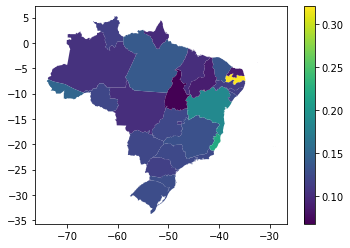

In [39]:
geo_letalidade_por_estado.plot(column="letalidade", legend=True)